# Assignment #7-8: Neural Networks

Construct a dataset framework for batched training, create your own implementations of common neural network operations, and train your model on the Fashion-MNIST dataset. Ue the PyTorch environment (install the API on your local machine).

## Load the Dataset

Use the provided utils.mnist_reader class to load the training data, which should contain 60000 training samples. Normalize the training sample values to the rande [0, 1] and visualize one random member from each of the 10 classes:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

In [1]:
from utils.mnist_reader import load_mnist

X, y =  load_mnist('data/fashion', kind='train')

In [2]:
X.shape, X

((60000, 784),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [3]:
y.shape, y

((60000,), array([9, 0, 0, ..., 3, 0, 5], dtype=uint8))

Let's first visualize the non-normalized random samples from each class.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

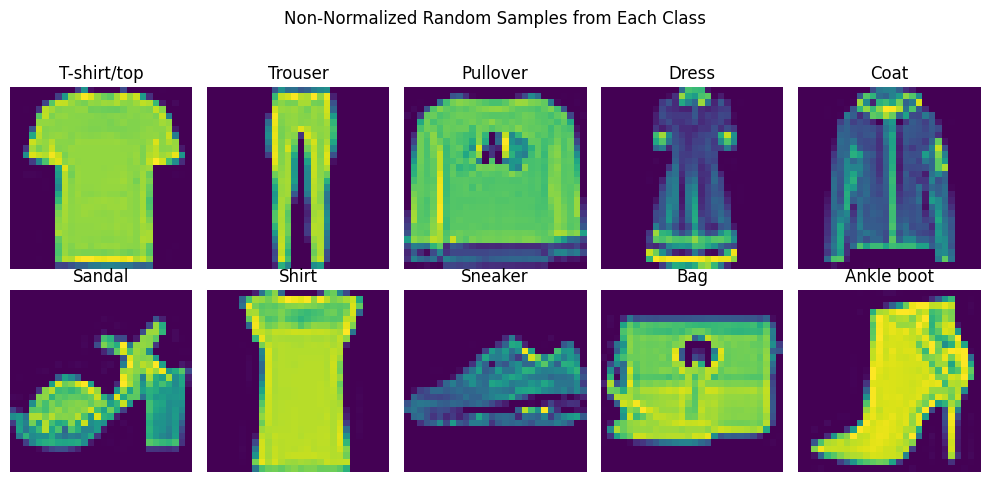

In [6]:
np.random.seed(42)

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('Non-Normalized Random Samples from Each Class')

for label in range(10):
  indices = np.where(y == label)[0]
  random_idx = np.random.choice(indices)

  sample = X[random_idx].reshape(28,28)
  axs[label // 5, label % 5].imshow(sample)
  axs[label // 5, label % 5].axis('off')
  axs[label // 5, label % 5].set_title(class_names[label])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

To normalize the values, for each sample we will take the minimum from all values, substract it from the chosen value, and then dividing by the difference btw maximum and minimum.
X_norm = (X - X_min) / (X_max - X_min)

In [7]:
X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))

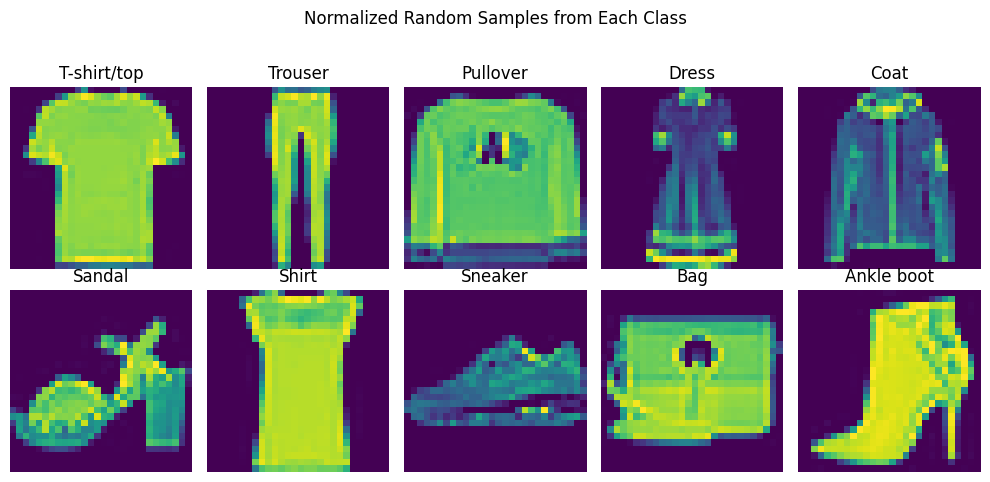

In [8]:
np.random.seed(42)

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('Normalized Random Samples from Each Class')

for label in range(10):
  indices = np.where(y == label)[0]
  random_idx = np.random.choice(indices)

  sample = X_norm[random_idx].reshape(28,28)
  axs[label // 5, label % 5].imshow(sample)
  axs[label // 5, label % 5].axis('off')
  axs[label // 5, label % 5].set_title(class_names[label])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Convert the Data to Tensors

First, we will split the data into two subsets: a training subset (80%) and a validation subset (20%).

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_size=0.2, random_state=42)

Before we continue, we also have to reshape the sample data in both subsets such that each sample corresponds to a 2D image with a single channel. The dimensions of each subset should be equal to [N, 1, 28, 28], where N denotes the total number of samples in the subset.

In [11]:
X_train = X_train.reshape(-1, 1, 28, 28)
X_train.shape

(48000, 1, 28, 28)

In [12]:
X_val = X_val.reshape(-1, 1, 28, 28)
X_val.shape

(12000, 1, 28, 28)

Now, we can convert both the samples and the labels of both subsets to PyTorch Tensors.

In [13]:
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('uint8'))

In [14]:
import torch

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.uint8)

In [16]:
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.uint8)

Additionally we will transform the class labels to one-hot-encodings.

In [17]:
y_train_tensor, y_val_tensor

(tensor([7, 3, 5,  ..., 6, 6, 1], dtype=torch.uint8),
 tensor([8, 8, 7,  ..., 8, 8, 1], dtype=torch.uint8))

In [18]:
import torch.nn.functional as F

In [19]:
num_classes = 10

y_train_tensor = F.one_hot(y_train_tensor.long(), num_classes).float()
y_val_tensor = F.one_hot(y_val_tensor.long(), num_classes).float()

In [20]:
y_train_tensor[0]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [21]:
y_val_tensor[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

## Implement the Dataset Class

This class will serve batched, randomly shuffled samples during training and validation.

In [22]:
class Dataset:

  def __init__(self, samples, labels, batch_size):
    # The matrix of data samples
    self.samples = samples
    # Number of samples
    self.number_of_samples = self.samples.shape[0]
    # The matrix of the corresponding labels
    self.labels = labels
    # The number of samples that are provided by calling __getitem__ method
    self.batch_size = batch_size
    # The length of the dataset in terms of batches
    self.length = int(np.ceil(self.number_of_samples / self.batch_size))
    # Permuted indices
    self.shuffle()


  def __getitem__(self, index):
    # Returns the data batch corresponding to the counter index
    idx_start = index * self.batch_size
    idx_end = min((index + 1) * self.batch_size, self.number_of_samples)
    indices = self.indices[idx_start:idx_end]

    return self.samples[indices], self.labels[indices]


  def __len__(self):
    # Returns the length of the dataset in terms of batches
    return self.length


  def shuffle(self):
    # Randomly permute the samples in the dataset
    self.indices = torch.randperm(self.number_of_samples)

Now let's use the Dataset class to create two datasets: training and validation.

In [23]:
dataset_train = Dataset(X_train_tensor, y_train_tensor, batch_size=128)
dataset_val = Dataset(X_val_tensor, y_val_tensor, batch_size=128)

Additionally we will visualize 16 samples from a batch belonging to the training dataset and their corresponding class labels.

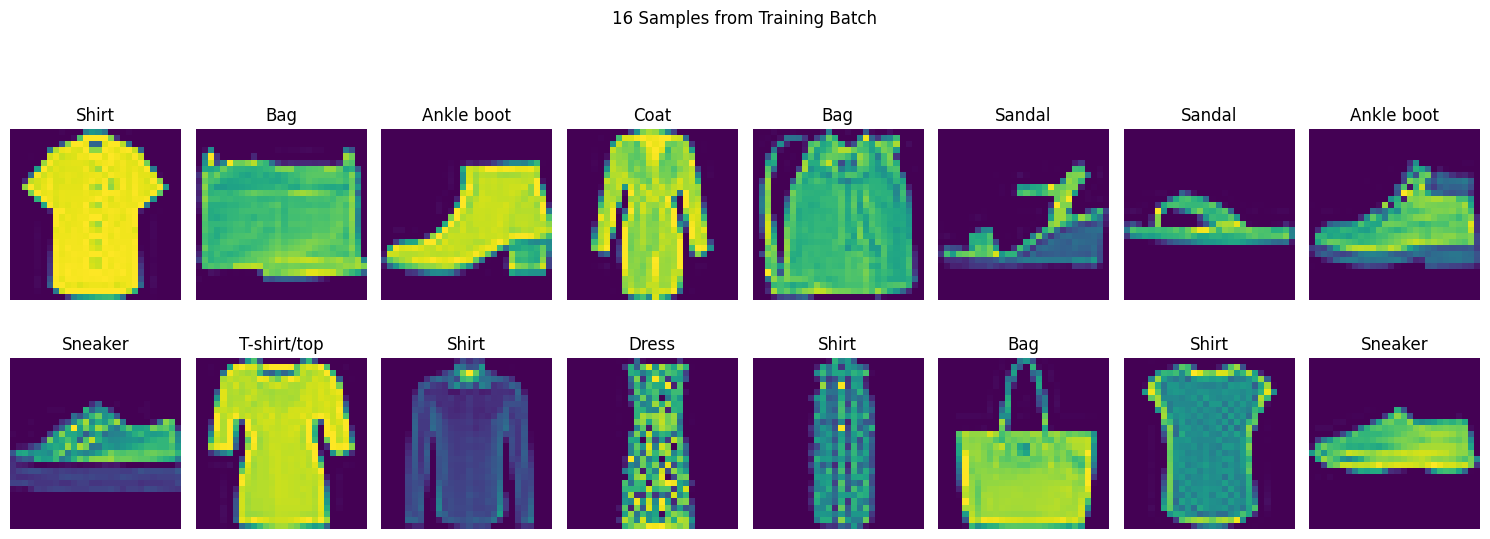

In [24]:
batch_samples_train, batch_labels_train = dataset_train[5]

fig, axs = plt.subplots(2, 8, figsize=(15, 6))
fig.suptitle('16 Samples from Training Batch')

for idx in range(16):
  sample = batch_samples_train[idx].squeeze().numpy()
  label = torch.argmax(batch_labels_train[idx]).item()

  axs[idx // 8, idx % 8].imshow(sample)
  axs[idx // 8, idx % 8].axis('off')
  axs[idx // 8, idx % 8].set_title(class_names[label])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Backbone of Classification Neural Network

In [25]:
import torch.nn as nn

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
x, y = dataset_train[0]
x = x.to(device)
x.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 10]))

The first operation we will need to implement is the **two-dimensional convolution**. After implementing it, we will compare it with the built in implementation in the PyTorch library.

In [28]:
class Conv2d(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size, stride, random_seed=None):
    super().__init__()

    if random_seed is not None:
      torch.manual_seed(random_seed)

    # Initializing weights using the Kaiming Initialization (designed specifically for NNs with ReLU) -> avoiding vanishing and exploding gradient
    self.weight = nn.Parameter(torch.empty((out_channels, in_channels, kernel_size, kernel_size), dtype=torch.float32))
    fan_in = in_channels * kernel_size * kernel_size
    std = torch.sqrt(torch.tensor(2.0 / fan_in))
    self.weight.data.normal_(0, std.item())
    # Initializing the bias to array of zeros
    self.bias = nn.Parameter(torch.zeros((out_channels,), dtype=torch.float32))
    # Initializing the stride
    self.stride = stride

  def forward(self, x):
    batch_size, in_channels, in_height, in_width  = x.size()
    out_channels, _, kernel_size, _ = self.weight.size()

    # Calculating the output dimensions
    out_height = ((in_height - kernel_size) // self.stride) + 1
    out_width = ((in_width - kernel_size) // self.stride) + 1

    # Unfold the input tensor and add the channels (reshape it)
    unfold = nn.Unfold(kernel_size=(kernel_size, kernel_size), stride=self.stride)
    unfolded_x = unfold(x)

    # Convolution
    weight = self.weight.view(out_channels, -1).t()
    output = unfolded_x.transpose(1,2).matmul(weight).transpose(1,2)

    # Fold it back
    fold = nn.Fold(output_size=(out_height, out_width), kernel_size=(1, 1))

    return fold(output) + self.bias.view(1, -1, 1, 1)

In [29]:
f0_conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1).to(device)
f1_conv2d = Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, random_seed=42).to(device)

f0_conv2d.weight = f1_conv2d.weight
f0_conv2d.bias = f1_conv2d.bias

y0_conv2d = f0_conv2d(x).cpu()
y1_conv2d = f1_conv2d(x).cpu()

dif_conv2d = (y0_conv2d - y1_conv2d).abs().max()

print(f"Maximal difference between our and built in 2D Convolution: {dif_conv2d}")
print(f"Difference is smaller than than 10^-5: {dif_conv2d < 1e-05}")

Maximal difference between our and built in 2D Convolution: 1.7881393432617188e-07
Difference is smaller than than 10^-5: True


Let's do the same for the **two-dimensional max pooling**.

In [30]:
class MaxPool2d(nn.Module):

  def __init__(self, kernel_size, stride):
    super().__init__()

    self.kernel_size = kernel_size
    self.stride = stride


  def forward(self, x):
    batch_size, in_channels, in_height, in_width  = x.size()

    # Calculating the output dimensions
    out_height = ((in_height - self.kernel_size) // self.stride) + 1
    out_width = ((in_width - self.kernel_size) // self.stride) + 1

    # Unfold the input tensor and add the channels (reshape it)
    unfold = nn.Unfold(kernel_size=(self.kernel_size, self.kernel_size), stride=self.stride)
    unfolded_x = unfold(x)

    # Reshape the unfolded tensor to include channels
    unfolded_x = unfolded_x.view(batch_size, in_channels, -1, out_height, out_width)

    # Max Pooling
    output, _ = torch.max(unfolded_x, dim=2)

    return output

In [31]:
f0_pool2d = nn.MaxPool2d(kernel_size=2, stride=2).to(device)
f1_pool2d = MaxPool2d(kernel_size=2, stride=2).to(device)

y0_pool2d = f0_pool2d(x).cpu()
y1_pool2d = f1_pool2d(x).cpu()

dif_pool2d = (y0_pool2d - y1_pool2d).abs().max()

print(f"Maximal difference between our and built in 2D Max Pooling: {dif_pool2d}")
print(f"Difference is smaller than than 10^-5: {dif_pool2d < 1e-05}")

Maximal difference between our and built in 2D Max Pooling: 0.0
Difference is smaller than than 10^-5: True


And the last operation, for which we will do the same, is the **Rectified Linear Unit (ReLU)**.

In [32]:
class ReLU(nn.Module):

  def __init__(self):
    super().__init__()


  def forward(self, x):
    return torch.max(x, torch.zeros_like(x))

In [33]:
f0_relu = nn.ReLU().to(device)
f1_relu = ReLU().to(device)

y0_relu = f0_relu(x).cpu()
y1_relu = f1_relu(x).cpu()

dif_relu = (y0_relu - y1_relu).abs().max()

print(f"Maximal difference between our and built in ReLU: {dif_relu}")
print(f"Difference is smaller than than 10^-5: {dif_relu < 1e-05}")

Maximal difference between our and built in ReLU: 0.0
Difference is smaller than than 10^-5: True


## Ordering of Operations

Let's examine how the ordering of operations inside the Neural Network affects the output. We will look at specific case of MaxPool2d and ReLU commutativity.

First let's create a PyTorch tensor with random elements in the range [-1, 1] of dimensions [1, 100, 100].

In [34]:
torch.manual_seed(42)

# Create the tensor containing random values in range [0,1]
random_tensor = torch.rand((1, 100, 100), dtype=torch.float32)

# Rescale the tensor [0, 2] - 1 = [-1, 1]
random_tensor = 2 * random_tensor - 1
print(random_tensor)

tensor([[[ 0.7645,  0.8300, -0.2343,  ..., -0.3374, -0.3545, -0.9676],
         [-0.5727,  0.2498, -0.1320,  ..., -0.0597,  0.2404,  0.2802],
         [-0.9083, -0.3690,  0.8421,  ..., -0.0780, -0.3330, -0.3235],
         ...,
         [-0.5961,  0.5636,  0.3876,  ..., -0.4213, -0.6570, -0.3510],
         [ 0.0961,  0.4030,  0.7364,  ...,  0.0269, -0.3397,  0.3504],
         [-0.7327, -0.6708, -0.7531,  ..., -0.5638,  0.8239, -0.1778]]])


Now let's pass the tensor through 2 different transformations individually:
- Function one is **2D Max Pooling** with kernel size 3 and stride 2, followed by **ReLU**.
- Function two is **ReLU** followed by **2D Max Pooling** with kernel size 3 and stride 2.

In [35]:
f_0 = nn.Sequential(
    MaxPool2d(kernel_size=3, stride=2),
    ReLU()
)
y_0 = f_0(random_tensor[:, None])
y_0

tensor([[[[0.8421, 0.9186, 0.2018,  ..., 0.8594, 0.9157, 0.9157],
          [0.8421, 0.8421, 0.8385,  ..., 0.6893, 0.3734, 0.9298],
          [0.6754, 0.7820, 0.7820,  ..., 0.9804, 0.8017, 0.9298],
          ...,
          [0.9861, 0.7837, 0.5589,  ..., 0.9720, 0.9896, 0.5561],
          [0.9861, 0.9004, 0.9004,  ..., 0.9464, 0.9464, 0.6455],
          [0.7364, 0.7364, 0.9110,  ..., 0.7132, 0.9569, 0.9569]]]])

In [36]:
f_1 = nn.Sequential(
    ReLU(),
    MaxPool2d(kernel_size=3, stride=2)
)
y_1 = f_1(random_tensor[:, None])
y_1

tensor([[[[0.8421, 0.9186, 0.2018,  ..., 0.8594, 0.9157, 0.9157],
          [0.8421, 0.8421, 0.8385,  ..., 0.6893, 0.3734, 0.9298],
          [0.6754, 0.7820, 0.7820,  ..., 0.9804, 0.8017, 0.9298],
          ...,
          [0.9861, 0.7837, 0.5589,  ..., 0.9720, 0.9896, 0.5561],
          [0.9861, 0.9004, 0.9004,  ..., 0.9464, 0.9464, 0.6455],
          [0.7364, 0.7364, 0.9110,  ..., 0.7132, 0.9569, 0.9569]]]])

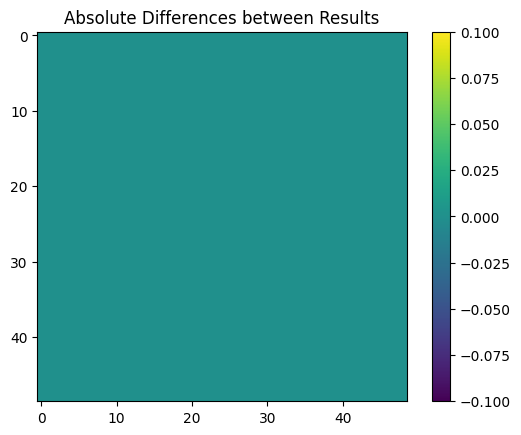

Maximal difference: 0.0


In [37]:
difference = torch.abs(y_0 - y_1)

plt.imshow(difference.squeeze().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Absolute Differences between Results')
plt.show()
print(f"Maximal difference: {difference.max()}")

For this combination of functions, the order is not so important and therefore the final results in both cases are the same. ReLU is removing the negative values and Max Pooling is getting the maximum value in specific window (3x3 in this case). If the value extracted by the max pooling is non-negative, it will remain so in both cases since ReLU won't change it. Similar is for the case when the value is negative - it will be set to 0 either cases and if the value extracted from the max pooling is negative or zero, this means the other values in the window are even smaller, so it doesn't matter if ReLU is before or after the pooling.

Let's see if that will change by replacing **Maximal Pooling** with **2D Convolution**.

In [38]:
f_2 = nn.Sequential(
    Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, random_seed=42),
    ReLU()
)
y_2 = f_2(random_tensor[:, None])
y_2

tensor([[[[0.0000, 1.1108, 0.3587,  ..., 0.0000, 0.4723, 0.0000],
          [0.0000, 0.4552, 0.0000,  ..., 0.0000, 0.3596, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6065, 0.9443],
          ...,
          [1.8795, 0.6743, 0.4500,  ..., 0.8075, 0.9008, 0.0000],
          [0.6581, 0.0000, 0.5919,  ..., 0.3785, 0.0000, 0.0000],
          [0.0000, 0.7368, 0.1736,  ..., 0.6270, 0.6795, 0.0000]]]],
       grad_fn=<MaximumBackward0>)

In [39]:
f_3 = nn.Sequential(
    ReLU(),
    Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, random_seed=42)
)
y_3 = f_3(random_tensor[:, None])
y_3

tensor([[[[ 0.2228,  0.8132,  0.0148,  ..., -0.1687,  0.4868,  0.1258],
          [-0.0892,  0.2267, -0.4438,  ...,  0.0631,  0.1709,  0.0258],
          [-0.1223, -0.4299, -0.1581,  ..., -0.0558,  0.2465,  0.6375],
          ...,
          [ 1.3398,  0.6743,  0.4944,  ...,  0.3770,  0.9312, -0.1815],
          [ 0.5906, -0.0078,  0.5717,  ...,  0.2777, -0.0668, -0.1399],
          [-0.1249,  0.6833,  0.0856,  ...,  0.1444,  0.7123,  0.1671]]]],
       grad_fn=<AddBackward0>)

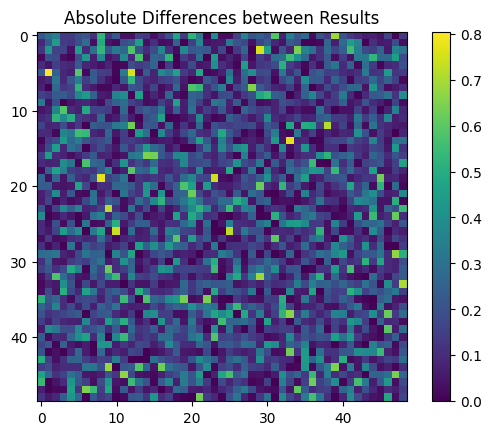

Maximal difference: 0.8043032884597778


In [40]:
difference = torch.abs(y_2 - y_3)

plt.imshow(difference.squeeze().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Absolute Differences between Results')
plt.show()
print(f"Maximal difference: {difference.max()}")

As expected, this is not the case here anymore. Changing the order of Convolution and ReLU also changes the final results. This is because the Convolution is not based on maximum value, but on multiplication instead. This means that some negative values in the input image can give us positive in the output image, which makes difference in the ReLU function, since they would be removed if the ReLU is before and the output will be completely different.

## Neural Network

Now let's define a Neural Network, which will produce a vector of 10 elements for each sample, predicting the class it belongs to. Our NN will consist of the following basic blocks:
1. 2D Convolution
2. 2D Max Pooling
3. ReLU

We will have 2 such blocks, which will be following one another. The kernel size of both the convolution and maximal pooling layers in both blocks will be 3. The output of the second block will be a tensor with the following dimensions [B, 64, 4, 4], where B is the batch size and 64 is the number of channels.

The model willl end with a single convolution layer with a kernel size of 4, which will produce 10 output channels. The output of this layer should therefore be a tensor with dimension equal to [B, 10, 1, 1]. Apply the flatten operation (nn.Flatten) on the last layer's output to generate the output of size [B, 10].

We also know that the inputted data into the network has the shape [B, 1, 28, 28].

In [41]:
class SubNetwork_Custom(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.f = nn.Sequential(
        Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1),
        MaxPool2d(kernel_size=3, stride=2),
        ReLU()
    )


  def forward(self, x):
    return self.f(x)

In [42]:
class Network_Custom(nn.Module):

  def __init__(self):
    super().__init__()

    self.f = nn.Sequential(
        SubNetwork_Custom(in_channels=1, out_channels=8),
        SubNetwork_Custom(in_channels=8, out_channels=64),
        Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
        nn.Flatten()
    )


  def forward(self, x):
    return self.f(x)

In [43]:
nn_custom = Network_Custom().to(device)
y_custom = nn_custom(x).cpu()

In [44]:
x.shape, y_custom.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 10]))

Let's also create a Network using the built in classes in PyTorch.

In [45]:
class SubNetwork(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.f = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.ReLU()
    )


  def forward(self, x):
    return self.f(x)

In [46]:
class Network(nn.Module):

  def __init__(self):
    super().__init__()

    self.f = nn.Sequential(
        SubNetwork(in_channels=1, out_channels=8),
        SubNetwork(in_channels=8, out_channels=64),
        nn.Conv2d(in_channels=64, out_channels=10, kernel_size=4, stride=1),
        nn.Flatten()
    )


  def forward(self, x):
    return self.f(x)

In [47]:
nn = Network().to(device)
y_nn = nn(x).cpu()

In [48]:
x.shape, y_nn.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 10]))

## Put it all together

We will use the **Stochastic Gradient Descent** algorithm (torch.optim.SGD) and the **Cross-Entropy** loss function (torch.nn.CrossEntropyLoss) to define a function fit, which takes the following two parameters:
- the model, which we will fit
- the number of epochs, denoting the number of times we will iterate over the training and the validation datasets.

The fit function should return the model that best performd on the validation dataset during training and a list of 10 training and validation losses, one for each epoch. We select the best model at the end of each epoch and not when we iterate through all epochs.

In [49]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

In [50]:
def fit(model, number_of_epochs, dataset_train, dataset_val, device):
  loader_train = DataLoader(dataset_train, batch_size=dataset_train.batch_size, shuffle=True, drop_last=True)
  loader_val = DataLoader(dataset_val, batch_size=dataset_val.batch_size, shuffle=False, drop_last=True)

  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1)

  best_model = None
  best_val_loss = float('inf')
  training_losses, validation_losses = [], []
  training_accuracies, validation_accuracies = [], []

  for epoch in range(number_of_epochs):
    # Training
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in loader_train:
      x = x[:, 0, :, :].to(device)
      y = y[:, 0, :].to(device)

      optimizer.zero_grad()
      p = model(x)
      loss = loss_function(p, y)
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()
      predicted = torch.argmax(p, dim=1)
      y = torch.argmax(y, dim=1)
      total_train += y.size(0)
      correct_train += (predicted == y).sum().item()

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
      for x, y in loader_val:
        x = x[:, 0, :, :].to(device)
        y = y[:, 0, :].to(device)

        p = model(x)
        loss = loss_function(p, y)
        total_val_loss += loss.item()
        predicted = torch.argmax(p, dim=1)
        y = torch.argmax(y, dim=1)
        total_val += y.size(0)
        correct_val += (predicted == y).sum().item()


    # Save losses and best model
    avg_train_loss = total_train_loss / len(loader_train)
    avg_val_loss = total_val_loss / len(loader_val)
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)

    # Save accuracies
    train_accuracy = correct_train / total_train
    val_accuracy = correct_val / total_val
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_model = model.state_dict()

  model.load_state_dict(best_model)

  return model, training_losses, validation_losses, training_accuracies, validation_accuracies

Now let's train both models (custom and PyTorch equivalent) for 10 epochs. The results will help us visualize the training and validation losses for all 10 epochs and both models. (difference in performance, potential sources)

In [51]:
import pandas as pd
import torch.nn as nn

In [52]:
dataset_train = Dataset(X_train_tensor, y_train_tensor, batch_size=32)
dataset_val = Dataset(X_val_tensor, y_val_tensor, batch_size=32)

In [53]:
torch.manual_seed(42)
nn_1 = Network_Custom().to(device)
best_model_1, training_losses_1, validation_losses_1, training_accuracies_1, validation_accuracies_1 = fit(nn_1, 10, dataset_train, dataset_val, device)

In [54]:
df_nn_1 = pd.DataFrame({'Training Loss': training_losses_1, 'Validation Loss': validation_losses_1, 'Training Accuracy': training_accuracies_1, 'Validation Accuracy': validation_accuracies_1})
df_nn_1

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy
0,1.690031,1.004431,0.502038,0.588068
1,0.838607,0.705372,0.690217,0.744318
2,0.692649,0.779336,0.752038,0.735795
3,0.632929,0.638154,0.774457,0.744318
4,0.583095,0.628589,0.794158,0.758523
5,0.517425,0.563869,0.826087,0.806818
6,0.498528,0.574718,0.815897,0.772727
7,0.499496,0.619613,0.819293,0.764205
8,0.455113,0.683930,0.841712,0.744318
9,0.434993,0.564844,0.838315,0.801136


In [55]:
torch.manual_seed(42)
nn_2 = Network().to(device)
best_model_2, training_losses_2, validation_losses_2, training_accuracies_2, validation_accuracies_2 = fit(nn_2, 10, dataset_train, dataset_val, device)

In [56]:
df_nn_2 = pd.DataFrame({'Training Loss': training_losses_2, 'Validation Loss': validation_losses_2, 'Training Accuracy': training_accuracies_2, 'Validation Accuracy': validation_accuracies_2})
df_nn_2

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy
0,1.893959,1.342289,0.319293,0.446023
1,1.109061,1.002281,0.570652,0.610795
2,0.866080,0.810137,0.677310,0.687500
3,0.756205,0.789064,0.715353,0.678977
4,0.690077,0.653747,0.737092,0.752841
5,0.663503,0.742660,0.760190,0.713068
6,0.612950,0.631453,0.779891,0.752841
7,0.600181,0.708821,0.782609,0.715909
8,0.571465,0.657872,0.789402,0.730114
9,0.558672,0.659715,0.792120,0.764205


Now let's evaluate both models by visualizing and comparing both the losses and the accuracy for both models at each epoch.

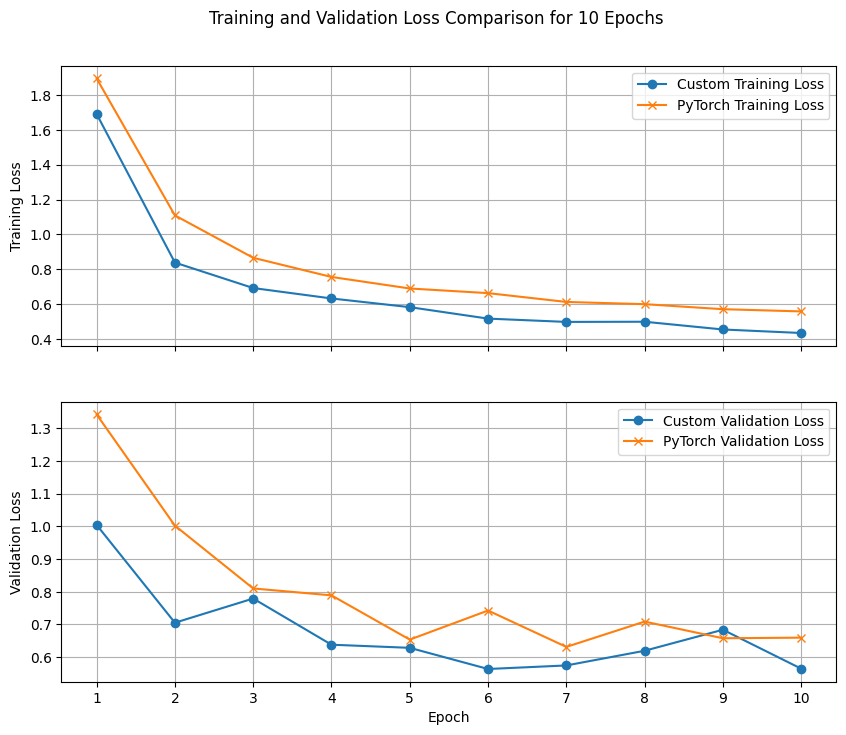

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(df_nn_1.index + 1, df_nn_1['Training Loss'], label='Custom Training Loss', marker='o')
ax2.plot(df_nn_1.index + 1, df_nn_1['Validation Loss'], label='Custom Validation Loss', marker='o')
ax1.plot(df_nn_2.index + 1, df_nn_2['Training Loss'], label='PyTorch Training Loss', marker='x')
ax2.plot(df_nn_2.index + 1, df_nn_2['Validation Loss'], label='PyTorch Validation Loss', marker='x')

ax1.set_ylabel('Training Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epoch')
fig.suptitle('Training and Validation Loss Comparison for 10 Epochs', y=0.95)

ax1.legend()
ax2.legend()
ax2.set_xticks(df_nn_1.index + 1)
ax2.set_xticklabels(df_nn_1.index + 1)
ax1.grid(True)
ax2.grid(True)
plt.show()

We can see that our general seems to have lower loss in general for both validation and training loss. The training loss seems to be decreasing the most after the 1st epoch, but we can see pretty big decreasing also between the 2nd and 6th epoch. After that the training loss stays pretty much the same for both models, but our implementation seems to have lower values.

The Validation loss on other hand doesn't descrease with each next epoch, but in general is still decreasing. We can see that the best value for our model is achieved in epoch 10. After epoch 6 the loss increases a bit and after epoch 9, it falls again. In general both models values seem to decrease similarly, but our implementation has lower loss for most of the epochs.

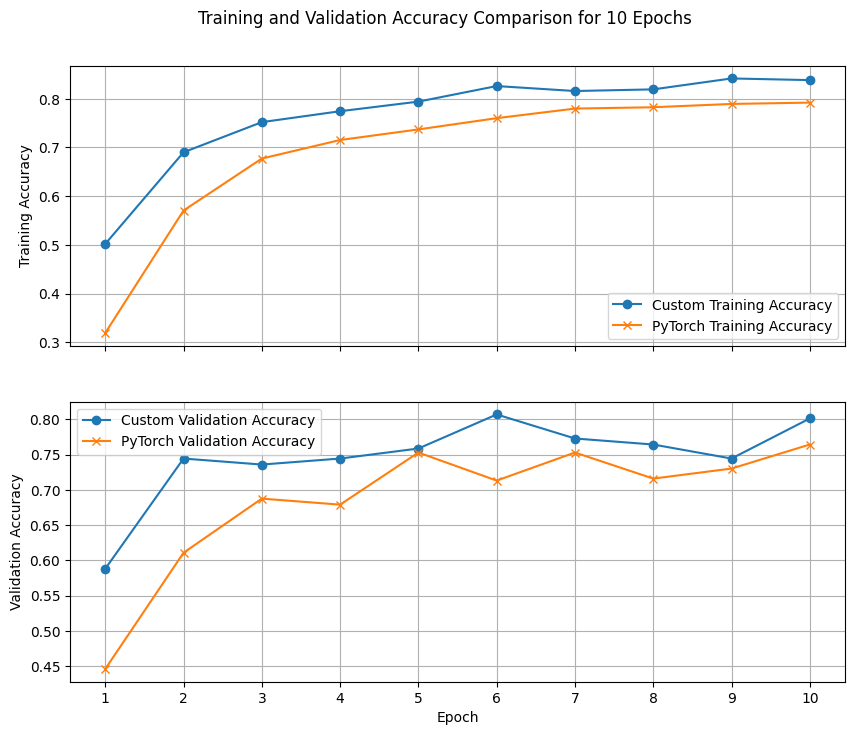

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(df_nn_1.index + 1, df_nn_1['Training Accuracy'], label='Custom Training Accuracy', marker='o')
ax2.plot(df_nn_1.index + 1, df_nn_1['Validation Accuracy'], label='Custom Validation Accuracy', marker='o')
ax1.plot(df_nn_2.index + 1, df_nn_2['Training Accuracy'], label='PyTorch Training Accuracy', marker='x')
ax2.plot(df_nn_2.index + 1, df_nn_2['Validation Accuracy'], label='PyTorch Validation Accuracy', marker='x')

ax1.set_ylabel('Training Accuracy')
ax2.set_ylabel('Validation Accuracy')
ax2.set_xlabel('Epoch')
fig.suptitle('Training and Validation Accuracy Comparison for 10 Epochs', y=0.95)

ax1.legend()
ax2.legend()
ax2.set_xticks(df_nn_1.index + 1)
ax2.set_xticklabels(df_nn_1.index + 1)
ax1.grid(True)
ax2.grid(True)
plt.show()

The Accuracy is another proof that our model performs better for each epoch. We can see that the training accuracy is slowly increasing for both models. The most it seems to be increasing from the 1st till the 2nd epoch, but there is some visible change also between epoch 2 and 6. After that the values don't change much for both models.

The Validation accuracy on other hand is a bit more chaotic, but in general it also increases. The biggest increase for both models is between epoch 1 and epoch 2. We can see that our model achieves the highest value for epoch 10 and that also here the value falls between epoch 6 and 9. In general both models seem to incease their values similarly, but our implementation has better accuracy.

The main reason for this differences lays in the different convolutional layers. The PyTorch implementation may have different weights, biases and even uses different functions to calculate the convolved image. But the most important factor are the initialization of the weights. Using random values to initialize the weights in our implementation gave us pretty low accuracy and twice bigger loss. Using Kaiming Initialization allowed us to avoid vanishing and explosion of gradient and improve our model drastically.